In [5]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

import pandas as pd
import numpy as np

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2024-03-01'

# TODO extend this test date
# PLOT_DATES_TEST_START = '2022-01-03'
# PLOT_DATES_TEST_END = '2023-12-29'
# ensemble_result_file = "result20222023.csv"

# TODO extend this test date
PLOT_DATES_TEST_START = '2019-01-03'
PLOT_DATES_TEST_END = '2020-12-28'
ensemble_result_file = "result20192022.csv"
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]


# TODO Try a longer date range, Some columns have issues over this date range
# Value to be removed
# value_to_remove = "DOW"
# # Create a new list without the specified string
# DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
# print(DOW_30_TICKER)
# PLOT_DATES_TEST_START = '2015-01-03'
# PLOT_DATES_TEST_END = '2023-12-29'




df = YahooDownloader(start_date = PLOT_DATES_TEST_START,
                     end_date = PLOT_DATES_TEST_END,
                     ticker_list = DOW_30_TICKER).fetch_data()


# # They replace close price with adjusted close price
# df = YahooDownloader(start_date = PLOT_DATES_TEST_START,
#                      end_date = PLOT_DATES_TEST_END,
#                      ticker_list = [
#     "AMGN",
#     "AAPL",
#     "AMAT",
#     "INTC",
#     "PCAR",
#     "PAYX",
#     "MSFT"]).fetch_data()

print(df.head())


# Count rows with any null values
null_rows_count = df.isnull().any(axis=1).sum()

print(f"Number of rows containing null values: {null_rows_count}")


print("Check for o-nulls")
print(df.notnull().all().all())

assert df.notnull().all().all()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (14500, 8)
         date        open        high         low       close     volume  \
0  2019-01-03   35.994999   36.430000   35.500000   33.989883  365248800   
1  2019-01-03  192.149994  194.179993  188.669998  158.693985    3973900   
2  2019-01-03   94.790001   95.180000   93.230003   86.313248    4776600   
3  2019-01-03  319.489990  319.739990  309.399994  302.100555    5705600   
4  2019-01-03  125.309998  125.500000  120.440002  106.257637    6165800   

    tic  day  
0  AAPL    3  
1  AMGN    3  
2   AXP    3  
3    BA    3  
4   CAT    3  
Number of rows containing null values: 0
Check for o-nulls
True


In [6]:
def calculate_final_investment(X, B, initial_investment, buy_cost=0.001, sell_cost=0.001):
    # Ensure both dataframes have the same index
    assert X.index.equals(B.index), "The indices of X and B must be the same."

    # Calculate log returns
    log_returns = np.log(X)
    
    # Calculate weighted log returns
    weighted_log_returns = (log_returns * B).sum(axis=1)
    
    # Calculate transaction costs
    transaction_costs = (B.diff().abs() * buy_cost).sum(axis=1) + (B.diff().abs() * sell_cost).sum(axis=1)
    transaction_costs.iloc[0] = 0  # No transaction cost for the first period
    
    # Adjust the returns by subtracting the transaction costs
    adjusted_weighted_log_returns = weighted_log_returns - transaction_costs
    
    # Calculate cumulative log returns
    cumulative_log_returns = adjusted_weighted_log_returns.cumsum()
    
    # Calculate cumulative return factor
    cumulative_return_factor = np.exp(cumulative_log_returns)
    
    # Calculate the final investment amount
    final_investment = initial_investment * cumulative_return_factor
    
    return final_investment

In [7]:
# Current and Target Weights
current_weights = pd.Series({'A': 0.5, 'B': 0.3, 'C': 0.2})
target_weights = pd.Series({'A': 0.4, 'B': 0.4, 'C': 0.2})

# Portfolio Value
portfolio_value = 100000

# Current Values
current_values = current_weights * portfolio_value

# Target Values
target_values = target_weights * portfolio_value

# Calculate Buy and Sell Amounts
buy_amounts = target_values[target_values > current_values] - current_values[target_values > current_values]
sell_amounts = current_values[current_values > target_values] - target_values[current_values > target_values]

print("Buy Amounts:\n", buy_amounts)
print("Sell Amounts:\n", sell_amounts)

Buy Amounts:
 B    10000.0
dtype: float64
Sell Amounts:
 A    10000.0
dtype: float64


In [8]:
import pandas as pd


df = pd.DataFrame(df)

print(df.dtypes)

# Pivot the DataFrame
pivot_df = df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)



# If we pivot and there are nulls, it means some dates dont have all prices
# Count rows with any null values
# Identify columns with null values
columns_with_nulls = df.columns[df.isnull().any()].tolist()

# Identify rows with null values
rows_with_nulls = pivot_df[pivot_df.isnull().any(axis=1)]

print("Columns with null values:", columns_with_nulls)
print("Rows with null values:\n", rows_with_nulls)

print("Check for o-nulls")
print(pivot_df.notnull().all().all())


assert pivot_df.notnull().all().all()


date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int32
dtype: object
tic               AAPL        AMGN         AXP          BA         CAT  \
date                                                                     
2019-01-03   33.989883  158.693985   86.313248  302.100555  106.257637   
2019-01-04   35.440903  164.118729   90.202568  317.822571  112.064171   
2019-01-07   35.362019  166.327240   90.692200  318.823425  112.134125   
2019-01-08   36.036129  168.460159   91.135628  330.891937  113.480812   
2019-01-09   36.648087  168.258652   91.301918  334.098450  113.918068   
...                ...         ...         ...         ...         ...   
2020-12-18  123.991386  203.171783  111.660400  219.750000  167.632858   
2020-12-21  125.528305  202.122513  110.615158  219.309998  166.891815   
2020-12-22  129.101395  196.502823  108.847755  218.779999  163.575455   
2020-12-23  128.200775  198.

In [9]:
import matplotlib.pyplot as plt
# plot normalized prices of these stocks
(pivot_df / pivot_df.iloc[0,:]).plot()

<Axes: xlabel='date'>

In [10]:
from online_algos import OLMAR, BCRP, CRP, BAH, TCO1, UP


# Simple Moving Average (SMA) vs. Exponential Moving Average (EMA)
# Simple Moving Average (SMA)
# Calculation: Averages the prices over a specified period.

# Sensitivity: Less sensitive to recent price changes because each period has equal weight.

# Lag: More lag compared to EMA, meaning it reacts slower to price changes.

# Use Case: Suitable for identifying longer-term trends.

# Exponential Moving Average (EMA)
# Calculation: Gives more weight to recent prices, making it more responsive.

# Sensitivity: More sensitive to recent price changes due to the weighting factor.

# Lag: Less lag compared to SMA, meaning it reacts faster to price changes.

# Use Case: Better for short-term trading strategies and identifying rapid changes.


algo = OLMAR(window=5, eps=10, ma_type="SMA")

result_olmar = algo.run(pivot_df)
print(result_olmar.summary())
result_olmar.plot()

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:233: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_al

Summary:
    Profit factor: 0.98
    Sharpe ratio: 0.18 ± 0.72
    Ulcer index: 0.23
    Information ratio (wrt benchmark): -0.37
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): -0.64 ± 0.71
    Beta / Alpha: 1.39 / -22.677%
    Annualized return: 9.02%
    Annualized volatility: 51.03%
    Longest drawdown: 462 days
    Max drawdown: 77.13%
    Winning days: 52.0%
    Annual turnover: 306.8
        


[<Axes: xlabel='date', ylabel='Total wealth'>,
 <Axes: xlabel='date', ylabel='weights'>]

In [11]:
olmar_B = result_olmar.B
olmar_X = result_olmar.X
print(result_olmar.summary())


result_olmar.fee = 0.001
print(result_olmar.summary())
result_olmar.plot()
olmar_B_fee = result_olmar.B
olmar_X_fee = result_olmar.X


c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 0.98
    Sharpe ratio: 0.18 ± 0.72
    Ulcer index: 0.23
    Information ratio (wrt benchmark): -0.37
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): -0.64 ± 0.71
    Beta / Alpha: 1.39 / -22.677%
    Annualized return: 9.02%
    Annualized volatility: 51.03%
    Longest drawdown: 462 days
    Max drawdown: 77.13%
    Winning days: 52.0%
    Annual turnover: 306.8
        
Summary:
    Profit factor: 0.86
    Sharpe ratio: -0.42 ± 0.74
    Ulcer index: -0.41
    Information ratio (wrt benchmark): -1.21
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): -1.51 ± 0.71
    Beta / Alpha: 1.39 / -53.361%
    Annualized return: -21.66%
    Annualized volatility: 51.01%
    Longest drawdown: 462 days
    Max drawdown: 83.27%
    Winning days: 48.7%
    Annual turnover: 306.8
        


# Cimpare results to makret

Summary:
    Profit factor: 0.96
    Sharpe ratio: -0.07 ± 1.01
    Ulcer index: -0.11
    Information ratio (wrt benchmark): 0.13
    Benchmark sharpe: -0.29 ± 1.03
    Appraisal ratio (wrt benchmark): 0.20 ± 1.01
    Beta / Alpha: 1.28 / 5.069%
    Annualized return: -2.37%
    Annualized volatility: 36.16%
    Longest drawdown: 218 days
    Max drawdown: 37.40%
    Winning days: 49.2%
    Annual turnover: 212.5
        
Summary:
    Profit factor: 0.87
    Sharpe ratio: -0.65 ± 1.11
    Ulcer index: -0.88
    Information ratio (wrt benchmark): -0.68
    Benchmark sharpe: -0.29 ± 1.03
    Appraisal ratio (wrt benchmark): -0.63 ± 1.01
    Beta / Alpha: 1.28 / -16.245%
    Annualized return: -23.62%
    Annualized volatility: 36.30%
    Longest drawdown: 218 days
    Max drawdown: 44.97%
    Winning days: 48.0%
    Annual turnover: 212.5


When factoring in the fees, our portiolo is underperfomring the market in sharpe ratio and returns

In [12]:
# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_olmar = calculate_final_investment(olmar_X, olmar_B, initial_investment, 0, 0)

print("Net Worth Over Time:")
print(net_worth_olmar)

s = pd.Series(net_worth_olmar, name='OLMAR_olmar')

# Convert Series to DataFrame
olmar_df = s.to_frame()

print(df)

# Plotting the net worth over time
plt.plot(net_worth_olmar.index, net_worth_olmar)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()


# with fees
# Calculate final investment amount
# Calculate the net worth over time
# TODO even a small fee on OLMAR seems to kill it
net_worth_olmar_fee = calculate_final_investment(olmar_X_fee, olmar_B_fee, initial_investment, 0.001, 0)

print("Net Worth Over Time:")
print(net_worth_olmar_fee)

s = pd.Series(net_worth_olmar_fee, name='OLMAR_olmar')

# Convert Series to DataFrame
olmar_df = s.to_frame()

print(df)

# Plotting the net worth over time
plt.plot(net_worth_olmar_fee.index, net_worth_olmar_fee)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.033162e+06
2019-01-07    1.037975e+06
2019-01-08    1.063519e+06
2019-01-09    1.065490e+06
                  ...     
2020-12-18    9.205658e+05
2020-12-21    8.992297e+05
2020-12-22    8.955442e+05
2020-12-23    9.033031e+05
2020-12-24    9.130012e+05
Length: 500, dtype: float64
             date        open        high         low       close     volume  \
0      2019-01-03   35.994999   36.430000   35.500000   33.989883  365248800   
1      2019-01-03  192.149994  194.179993  188.669998  158.693985    3973900   
2      2019-01-03   94.790001   95.180000   93.230003   86.313248    4776600   
3      2019-01-03  319.489990  319.739990  309.399994  302.100555    5705600   
4      2019-01-03  125.309998  125.500000  120.440002  106.257637    6165800   
...           ...         ...         ...         ...         ...        ...   
14495  2020-12-24  336.440002  341.410004  336.440002  323.089172    1360600   
14496  20

C:\Users\bencj\AppData\Local\Temp\ipykernel_9808\536080037.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\bencj\AppData\Local\Temp\ipykernel_9808\536080037.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Other stuff
=======================================

In [13]:
algo = BCRP(no_cash=True)
result = algo.run(pivot_df)

bcrp_B = result.B
print(result.B)
bcrp_X = result.X
print(result.X)
print(result.summary())
result.plot();

tic         AAPL          AMGN           AXP   BA           CAT  CRM  CSCO  \
date                                                                         
2019-01-03   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2019-01-04   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2019-01-07   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2019-01-08   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2019-01-09   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
...          ...           ...           ...  ...           ...  ...   ...   
2020-12-18   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2020-12-21   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2020-12-22   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2020-12-23   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15  0.0   0.0   
2020-12-24   1.0  3.400058e-16  2.359224e-16  0.0  1.568190e-15 

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

In [14]:
algo = BCRP(no_cash=True)
result_fee = algo.run(pivot_df)


# Here try setting a transaction fee
# Doesnt seem to do anything on BCRP becuase it doesn really change stocks
result_fee.fee = 0.01



bcrp_B_fee = result_fee.B
bcrp_X_fee = result_fee.X
print(result_fee.summary())
result_fee.plot();

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.40
    Sharpe ratio: 2.00 ± 1.23
    Ulcer index: 8.80
    Information ratio (wrt benchmark): 2.06
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): 2.02 ± 0.71
    Beta / Alpha: 1.03 / 51.214%
    Annualized return: 74.61%
    Annualized volatility: 37.25%
    Longest drawdown: 80 days
    Max drawdown: 31.43%
    Winning days: 56.6%
    Annual turnover: 0.0
        


In [15]:


# # Example DataFrame for price relatives (X)
# X = pd.DataFrame({
#     'AAPL': [0.01, 0.02, -0.01],
#     'GOOG': [0.02, 0.01, 0.03],
#     'IBM': [-0.01, 0.03, 0.02],
#     'MSFT': [0.03, 0.00, 0.01]
# }, index=pd.date_range(start='2020-01-01', periods=3))

# print(X)

# # Example DataFrame for portfolio weights (B)
# B = pd.DataFrame({
#     'AAPL': [0.25, 0.25, 0.00],
#     'GOOG': [0.25, 0.25, 1.00],
#     'IBM':  [0.25, 0.25, 0.00],
#     'MSFT': [0.25, 0.25, 0.00]
# }, index=pd.date_range(start='2020-01-01', periods=3))

# print(B)

# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_bcrp_fee = calculate_final_investment(bcrp_X_fee, bcrp_B_fee, initial_investment)

print("Net Worth Over Time:")
print(net_worth_bcrp_fee)

s = pd.Series(net_worth_bcrp_fee, name='BCRP')

# Convert Series to DataFrame
olmar_bcrp_df = s.to_frame()

print(df)

# Plotting the net worth over time
plt.plot(net_worth_bcrp_fee.index, net_worth_bcrp_fee)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.042690e+06
2019-01-07    1.040369e+06
2019-01-08    1.060202e+06
2019-01-09    1.078206e+06
                  ...     
2020-12-18    3.647891e+06
2020-12-21    3.693108e+06
2020-12-22    3.798230e+06
2020-12-23    3.771733e+06
2020-12-24    3.800822e+06
Length: 500, dtype: float64
             date        open        high         low       close     volume  \
0      2019-01-03   35.994999   36.430000   35.500000   33.989883  365248800   
1      2019-01-03  192.149994  194.179993  188.669998  158.693985    3973900   
2      2019-01-03   94.790001   95.180000   93.230003   86.313248    4776600   
3      2019-01-03  319.489990  319.739990  309.399994  302.100555    5705600   
4      2019-01-03  125.309998  125.500000  120.440002  106.257637    6165800   
...           ...         ...         ...         ...         ...        ...   
14495  2020-12-24  336.440002  341.410004  336.440002  323.089172    1360600   
14496  20

C:\Users\bencj\AppData\Local\Temp\ipykernel_9808\2567805052.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [16]:
import pandas as pd
import numpy as np

# # Example DataFrame for price relatives (X)
# X = pd.DataFrame({
#     'AAPL': [0.01, 0.02, -0.01],
#     'GOOG': [0.02, 0.01, 0.03],
#     'IBM': [-0.01, 0.03, 0.02],
#     'MSFT': [0.03, 0.00, 0.01]
# }, index=pd.date_range(start='2020-01-01', periods=3))

# print(X)

# # Example DataFrame for portfolio weights (B)
# B = pd.DataFrame({
#     'AAPL': [0.25, 0.25, 0.00],
#     'GOOG': [0.25, 0.25, 1.00],
#     'IBM':  [0.25, 0.25, 0.00],
#     'MSFT': [0.25, 0.25, 0.00]
# }, index=pd.date_range(start='2020-01-01', periods=3))

# print(B)

# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_bcrp = calculate_final_investment(bcrp_X, bcrp_B, initial_investment)

print("Net Worth Over Time:")
print(net_worth_bcrp)

s = pd.Series(net_worth_bcrp, name='BCRP')

# Convert Series to DataFrame
bcrp_df = s.to_frame()

print(df)

# Plotting the net worth over time
plt.plot(net_worth_bcrp.index, net_worth_bcrp)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.042690e+06
2019-01-07    1.040369e+06
2019-01-08    1.060202e+06
2019-01-09    1.078206e+06
                  ...     
2020-12-18    3.647891e+06
2020-12-21    3.693108e+06
2020-12-22    3.798230e+06
2020-12-23    3.771733e+06
2020-12-24    3.800822e+06
Length: 500, dtype: float64
             date        open        high         low       close     volume  \
0      2019-01-03   35.994999   36.430000   35.500000   33.989883  365248800   
1      2019-01-03  192.149994  194.179993  188.669998  158.693985    3973900   
2      2019-01-03   94.790001   95.180000   93.230003   86.313248    4776600   
3      2019-01-03  319.489990  319.739990  309.399994  302.100555    5705600   
4      2019-01-03  125.309998  125.500000  120.440002  106.257637    6165800   
...           ...         ...         ...         ...         ...        ...   
14495  2020-12-24  336.440002  341.410004  336.440002  323.089172    1360600   
14496  20

C:\Users\bencj\AppData\Local\Temp\ipykernel_9808\974869058.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Empty DataFrame
Columns: [ensemble, dji, BCRP]
Index: []


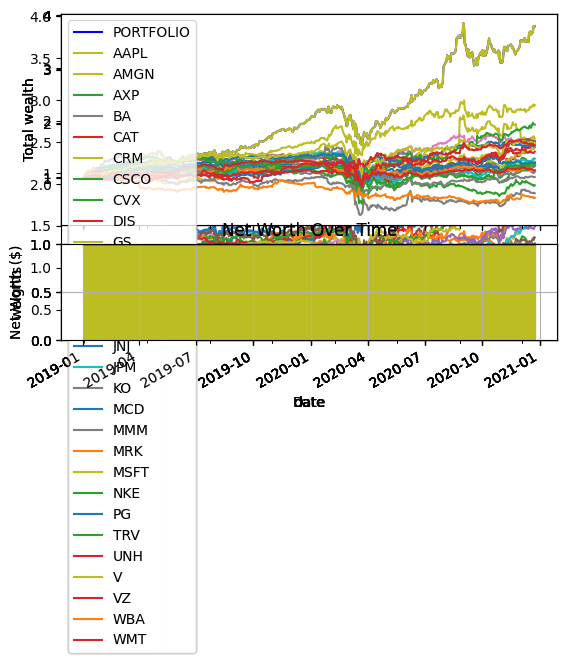

<Figure size 1500x500 with 0 Axes>

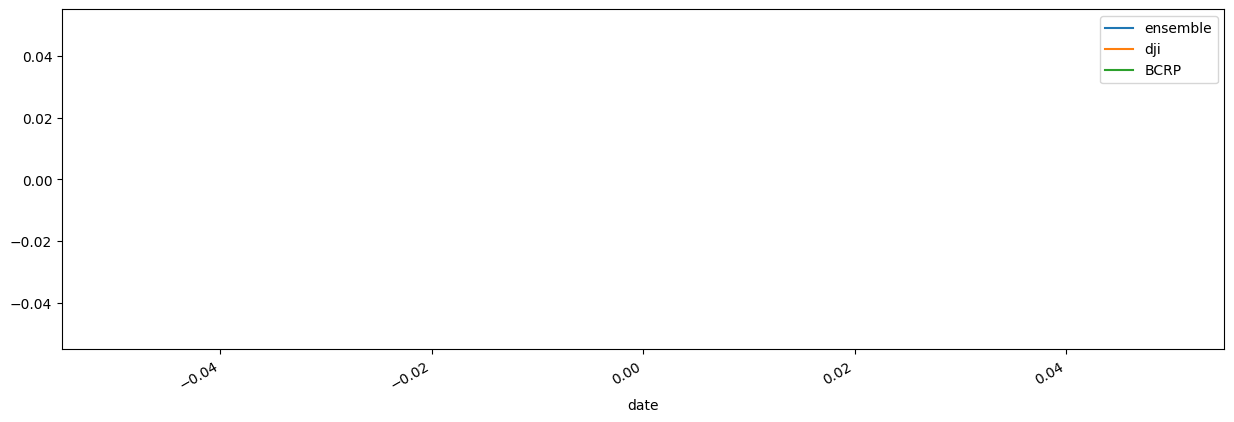

In [17]:
result = pd.DataFrame()
result = pd.read_csv("result20222023.csv")

result.set_index('date', inplace=True)

result.index = pd.to_datetime(result.index)

bcrp_df.index = pd.to_datetime(bcrp_df.index)

# Join DataFrames on date index
merged_df = result.join(bcrp_df, how='inner')
print(merged_df)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
merged_df.plot();

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.86 ± 0.83
    Ulcer index: 3.16
    Information ratio (wrt benchmark): 0.00
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): 0.00 ± 0.71
    Beta / Alpha: 1.00 / 0.000%
    Annualized return: 22.74%
    Annualized volatility: 26.59%
    Longest drawdown: 136 days
    Max drawdown: 33.09%
    Winning days: 57.1%
    Annual turnover: 2.5
        


c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.85 ± 0.83
    Ulcer index: 3.11
    Information ratio (wrt benchmark): -26.07
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): -2.28 ± 0.71
    Beta / Alpha: 1.00 / -0.250%
    Annualized return: 22.49%
    Annualized volatility: 26.58%
    Longest drawdown: 136 days
    Max drawdown: 33.12%
    Winning days: 57.1%
    Annual turnover: 2.5
        


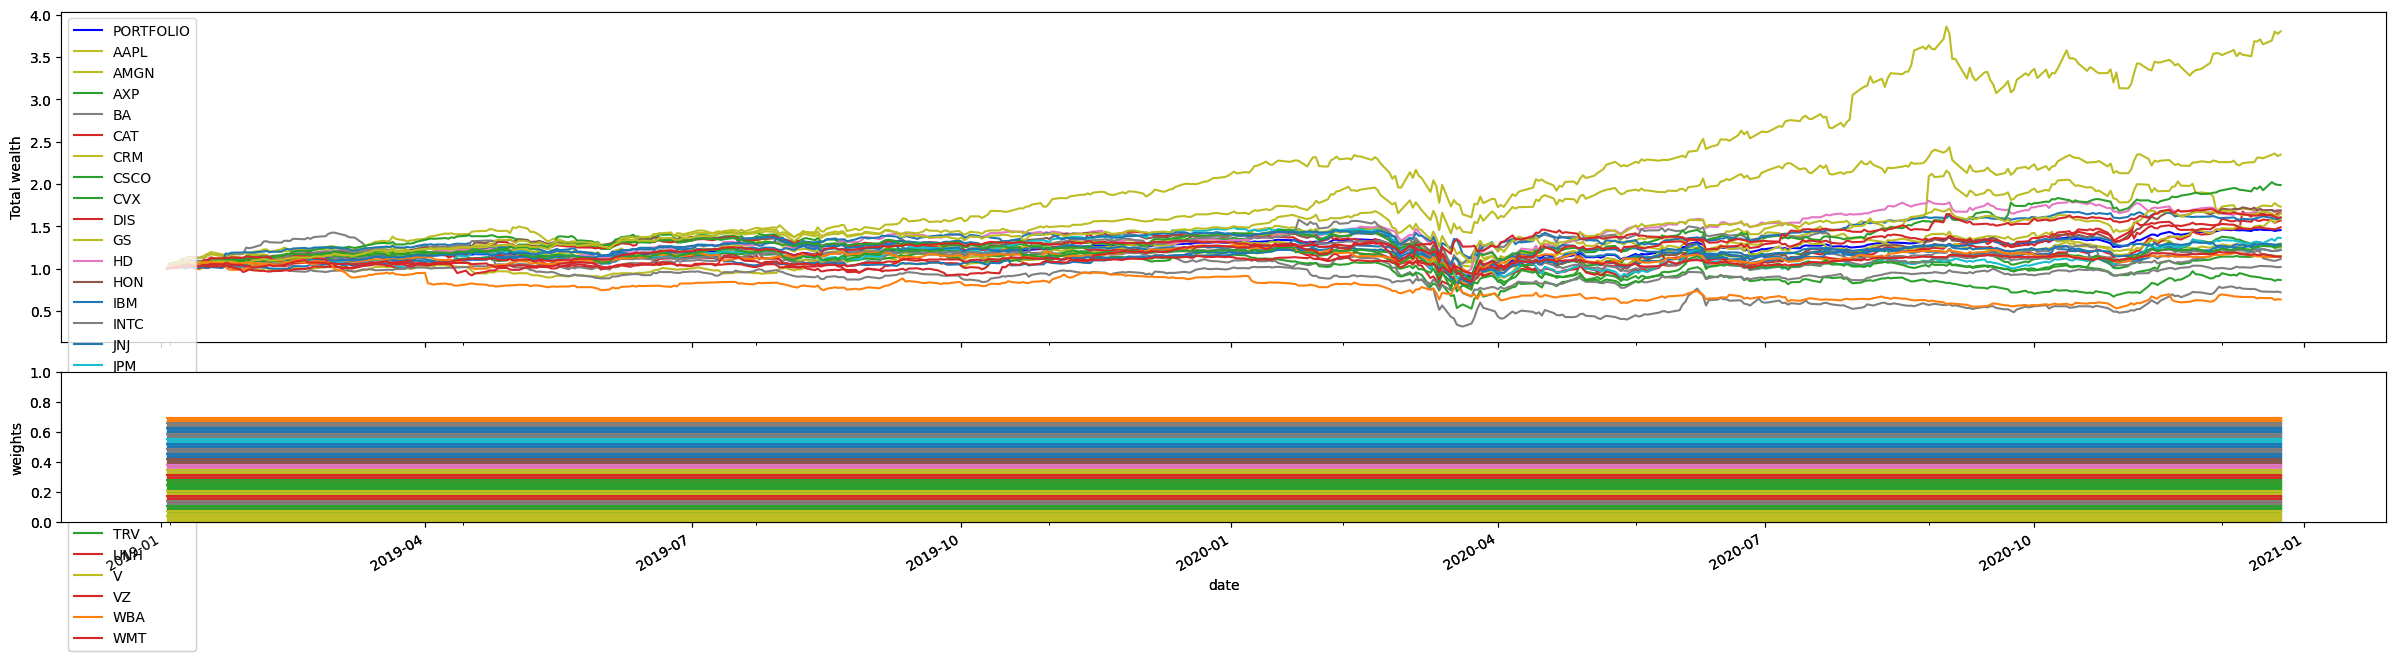

In [18]:
algo = CRP()
result = algo.run(pivot_df)

crp_B = result.B
crp_X = result.X
print(result.summary())
result.plot();



# Here try setting a transaction fee
result.fee = 0.001



crp_B_fee = result.B
crp_X_fee = result.X
print(result.summary())
result.plot();

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.033162e+06
2019-01-07    1.038583e+06
2019-01-08    1.048708e+06
2019-01-09    1.050982e+06
                  ...     
2020-12-18    1.375943e+06
2020-12-21    1.374637e+06
2020-12-22    1.364771e+06
2020-12-23    1.370678e+06
2020-12-24    1.373874e+06
Length: 500, dtype: float64
             date        open        high         low       close     volume  \
0      2019-01-03   35.994999   36.430000   35.500000   33.989883  365248800   
1      2019-01-03  192.149994  194.179993  188.669998  158.693985    3973900   
2      2019-01-03   94.790001   95.180000   93.230003   86.313248    4776600   
3      2019-01-03  319.489990  319.739990  309.399994  302.100555    5705600   
4      2019-01-03  125.309998  125.500000  120.440002  106.257637    6165800   
...           ...         ...         ...         ...         ...        ...   
14495  2020-12-24  336.440002  341.410004  336.440002  323.089172    1360600   
14496  20

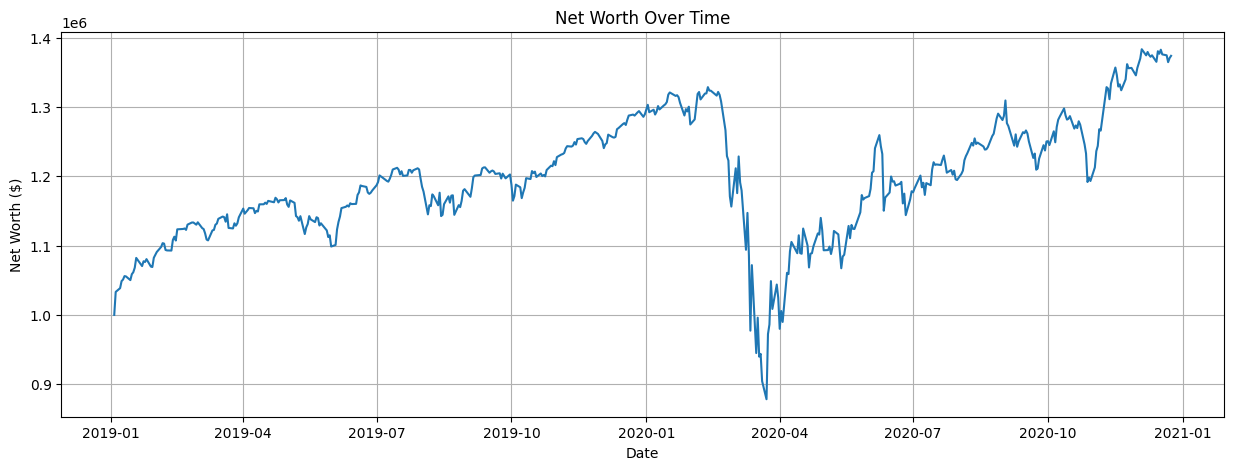

In [19]:
# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_crp = calculate_final_investment(crp_X, crp_B, initial_investment)

print("Net Worth Over Time:")
print(net_worth_crp)

s = pd.Series(net_worth_crp, name='CRP')

# Convert Series to DataFrame
crp_df = s.to_frame()

print(df)

# Plotting the net worth over time
plt.plot(net_worth_crp.index, net_worth_crp)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

# How do we handle transaction cost here for online

The widely adopted transaction costs model is the proportional transaction costs model in which the incurred transaction cost is proportional
to the wealth transferred during rebalancing.

In [20]:
# algo = TCO1(no_cash=True)
# result = algo.run(list_result)

# tco_B = result.B
# print(result.B)
# tco_X = result.X
# print(result.X)
# print(result.summary())
# result.plot();

In [21]:
# # Initial investment amount
# initial_investment = 1000000

# # Calculate final investment amount
# # Calculate the net worth over time
# net_worth_tco = calculate_final_investment(tco_X, tco_B, initial_investment, 0 ,0)

# print("Net Worth Over Time:")
# print(net_worth_tco)

# s = pd.Series(net_worth_tco, name='OLMAR_tco')

# # Convert Series to DataFrame
# olmar_tco_df = s.to_frame()

# print(df)

# # Plotting the net worth over time
# plt.plot(net_worth_tco.index, net_worth_tco)
# plt.xlabel('Date')
# plt.ylabel('Net Worth ($)')
# plt.title('Net Worth Over Time')
# plt.grid(True)
# plt.show()


# result = pd.DataFrame()
# result = pd.read_csv("result.csv")

# result.set_index('date', inplace=True)

# print(result)
# print(result.dtypes)
# result.index = pd.to_datetime(result.index)

# print(olmar_tco_df)
# print(result.dtypes)
# olmar_tco_df.index = pd.to_datetime(olmar_tco_df.index)

# # Join DataFrames on date index
# merged_df = result.join(olmar_tco_df, how='inner')
# print(merged_df)


# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,5)
# plt.figure();
# merged_df.plot();

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.86 ± 0.83
    Ulcer index: 3.17
    Information ratio (wrt benchmark): 0.41
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): 0.38 ± 0.71
    Beta / Alpha: 1.00 / 0.079%
    Annualized return: 22.78%
    Annualized volatility: 26.55%
    Longest drawdown: 135 days
    Max drawdown: 33.06%
    Winning days: 57.1%
    Annual turnover: 2.4
        


c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.85 ± 0.83
    Ulcer index: 3.12
    Information ratio (wrt benchmark): -1.72
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): -0.78 ± 0.71
    Beta / Alpha: 1.00 / -0.163%
    Annualized return: 22.54%
    Annualized volatility: 26.55%
    Longest drawdown: 136 days
    Max drawdown: 33.09%
    Winning days: 56.7%
    Annual turnover: 2.4
        


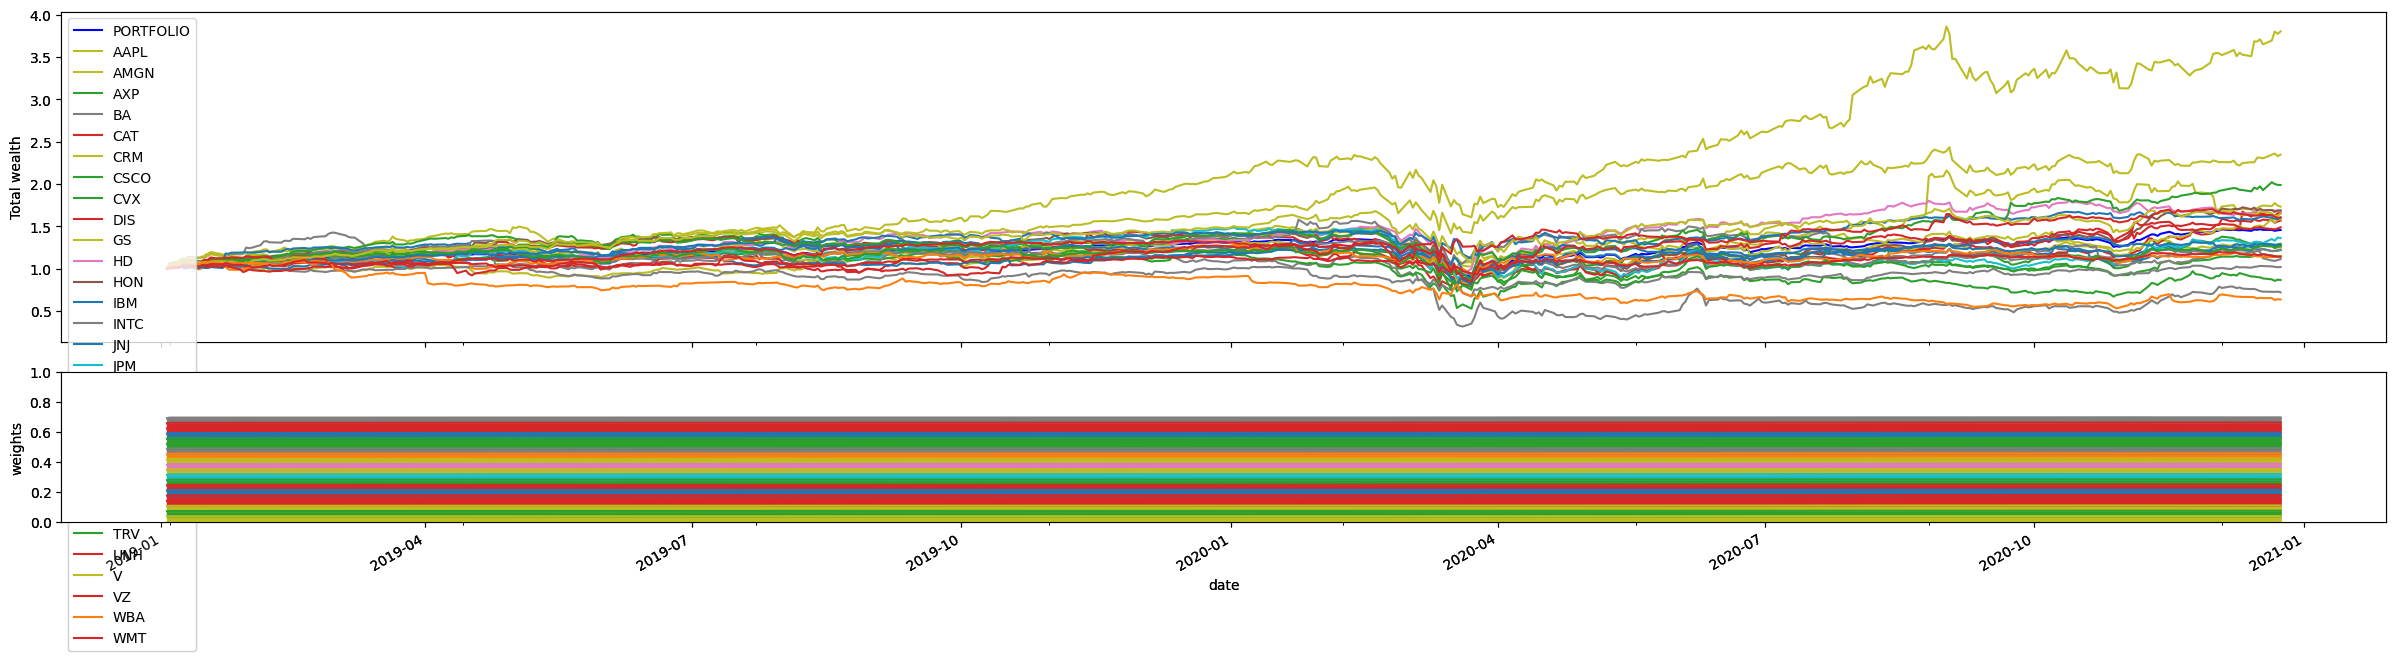

In [22]:
algo = UP()
result = algo.run(pivot_df)

up_B_fee = result.B
up_X_fee = result.X
print(result.summary())
result.plot();

result_fee = result


# Here try setting a transaction fee
result_fee.fee = 0.001



up_B_fee = result_fee.B
up_X_fee = result_fee.X
print(result_fee.summary())
result_fee.plot();

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.033116e+06
2019-01-07    1.038531e+06
2019-01-08    1.048651e+06
2019-01-09    1.050923e+06
                  ...     
2020-12-18    1.377124e+06
2020-12-21    1.375974e+06
2020-12-22    1.366231e+06
2020-12-23    1.372064e+06
2020-12-24    1.375303e+06
Length: 500, dtype: float64


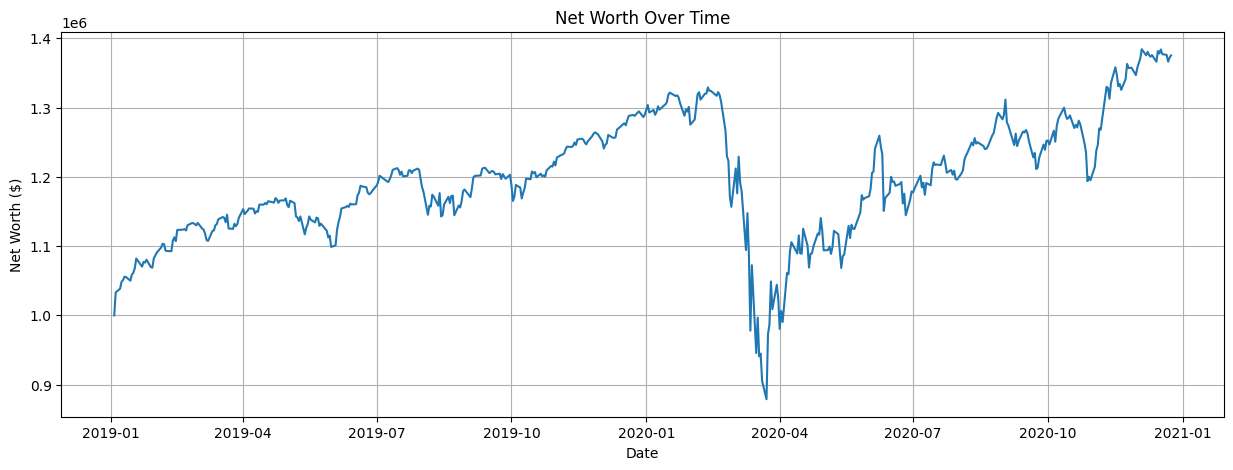

In [23]:
# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_up = calculate_final_investment(up_X_fee, up_B_fee, initial_investment, 0.001, 0.001)

print("Net Worth Over Time:")
print(net_worth_up)

s = pd.Series(net_worth_up, name='up')

# Convert Series to DataFrame
up_df_fee = s.to_frame()

# Plotting the net worth over time
plt.plot(net_worth_up.index, net_worth_up)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

                ensemble           dji            up
date                                                
2019-01-03  1.000000e+06  1.000000e+06  1.000000e+06
2019-01-04  1.006198e+06  1.032925e+06  1.033116e+06
2019-01-07  1.008966e+06  1.037253e+06  1.038531e+06
2019-01-08  1.017043e+06  1.048542e+06  1.048651e+06
2019-01-09  1.019192e+06  1.052583e+06  1.050923e+06
...                  ...           ...           ...
2020-12-18  1.375756e+06  1.330281e+06  1.377124e+06
2020-12-21  1.376612e+06  1.331930e+06  1.375974e+06
2020-12-22  1.374806e+06  1.323072e+06  1.366231e+06
2020-12-23  1.377590e+06  1.328111e+06  1.372064e+06
2020-12-24  1.380477e+06  1.331199e+06  1.375303e+06

[500 rows x 3 columns]


<Figure size 1500x500 with 0 Axes>

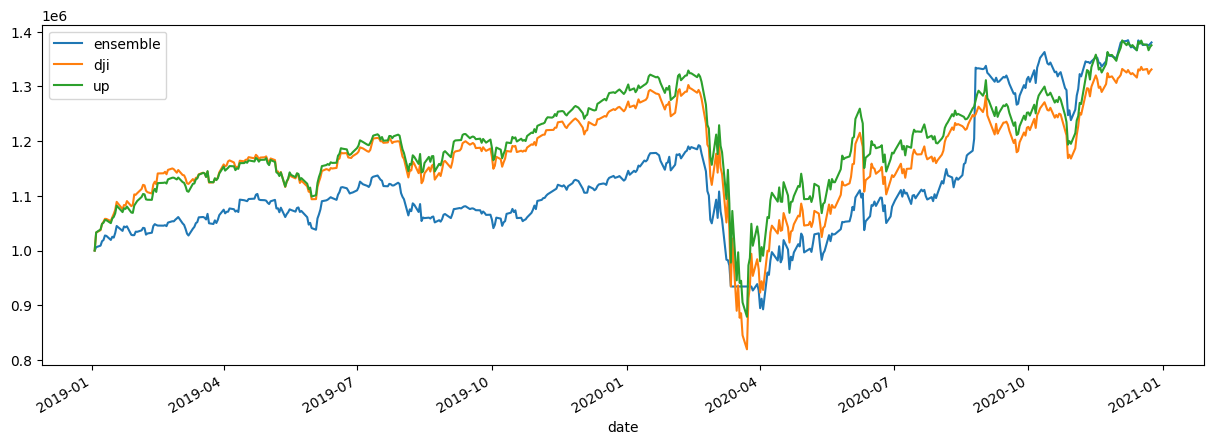

In [24]:
# TODO follow up on this??? How do I factor in the transaction cost here?

result = pd.DataFrame()

# TODO Change result period to use saved file
result = pd.read_csv(ensemble_result_file)

result.set_index('date', inplace=True)

result.index = pd.to_datetime(result.index)

up_df_fee.index = pd.to_datetime(up_df_fee.index)

# Join DataFrames on date index
merged_df = result.join(up_df_fee, how='inner')
print(merged_df)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
merged_df.plot();

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (499, 8)
Annual return          0.154077
Cumulative returns     0.328111
Annual volatility      0.275422
Sharpe ratio           0.660169
Calmar ratio           0.415456
Stability              0.099859
Max drawdown          -0.370862
Omega ratio            1.156820
Sortino ratio          0.911544
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.863107
Daily value at risk   -0.033978
dtype: float64
df_dji:            date           dji
0   2019-01-03  1.000000e+06
1   2019-01-04  1.032925e+06
2   2019-01-07  1.037253e+06
3   2019-01-08  1.048542e+06
4   2019-01-09  1.052583e+06
..         ...           ...
495 2020-12-18  1.330281e+06
496 2020-12-21  1.331930e+06
497 2020-12-22  1.323072e+06
498 2020-12-23  1.328111e+06
499 2020-12-24           NaN

[500 rows x 2 columns]
df_dji:                       dji
date                    
2019-01-03  1.000000e+06
2019-01-04  1.032925e+06
2019-

<Figure size 1500x500 with 0 Axes>

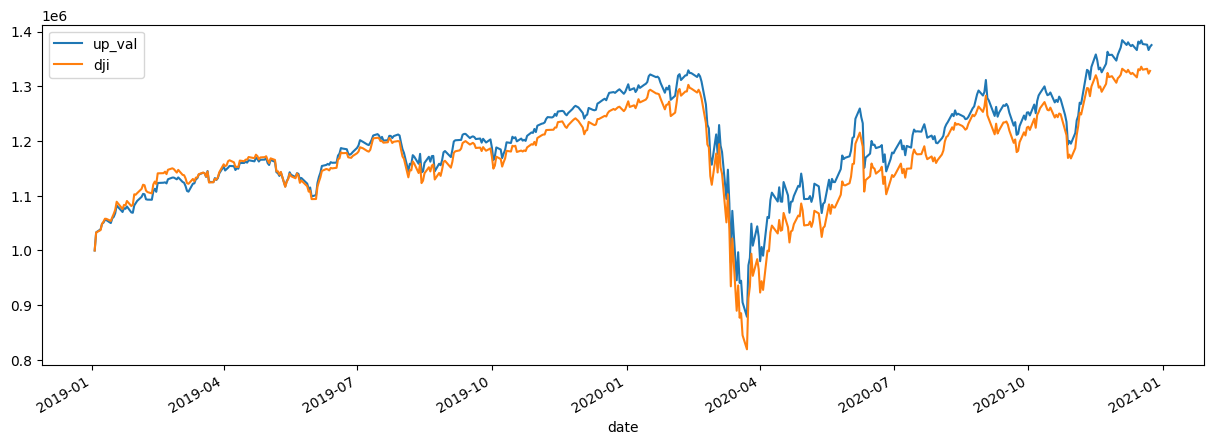

In [25]:
# Try comparing against baseline without ensemble


from finrl.plot import backtest_stats,  get_baseline

first_date = up_df_fee.index.min()
last_date = up_df_fee.index.max()

print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = first_date,
        end = last_date)

stats = backtest_stats(df_dji_, value_col_name = 'close')


df_dji = pd.DataFrame()
df_dji['date'] = up_df_fee.index
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * initial_investment
print("df_dji: ", df_dji)
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


df_result_up = pd.DataFrame({'date': up_df_fee.index, 'up_val': up_df_fee['up']})
df_result_up = df_result_up.set_index('date')

print("df_result_up.columns: ", df_result_up.columns)

print("df_result_up: ", df_result_up)
print("==============Compare to DJIA===========")
result = pd.DataFrame()

result = pd.merge(df_result_up, df_dji, left_index=True, right_index=True)
print("result: ", result)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();


# BAH basline

=====================

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.86 ± 0.83
    Ulcer index: 3.08
    Information ratio (wrt benchmark): -0.08
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): 0.14 ± 0.71
    Beta / Alpha: 0.98 / 0.361%
    Annualized return: 22.53%
    Annualized volatility: 26.05%
    Longest drawdown: 134 days
    Max drawdown: 32.70%
    Winning days: 57.1%
    Annual turnover: 0.0
        


c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:242: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.86 ± 0.83
    Ulcer index: 3.08
    Information ratio (wrt benchmark): -0.08
    Benchmark sharpe: 0.86 ± 0.83
    Appraisal ratio (wrt benchmark): 0.14 ± 0.71
    Beta / Alpha: 0.98 / 0.361%
    Annualized return: 22.53%
    Annualized volatility: 26.05%
    Longest drawdown: 134 days
    Max drawdown: 32.70%
    Winning days: 57.1%
    Annual turnover: 0.0
        


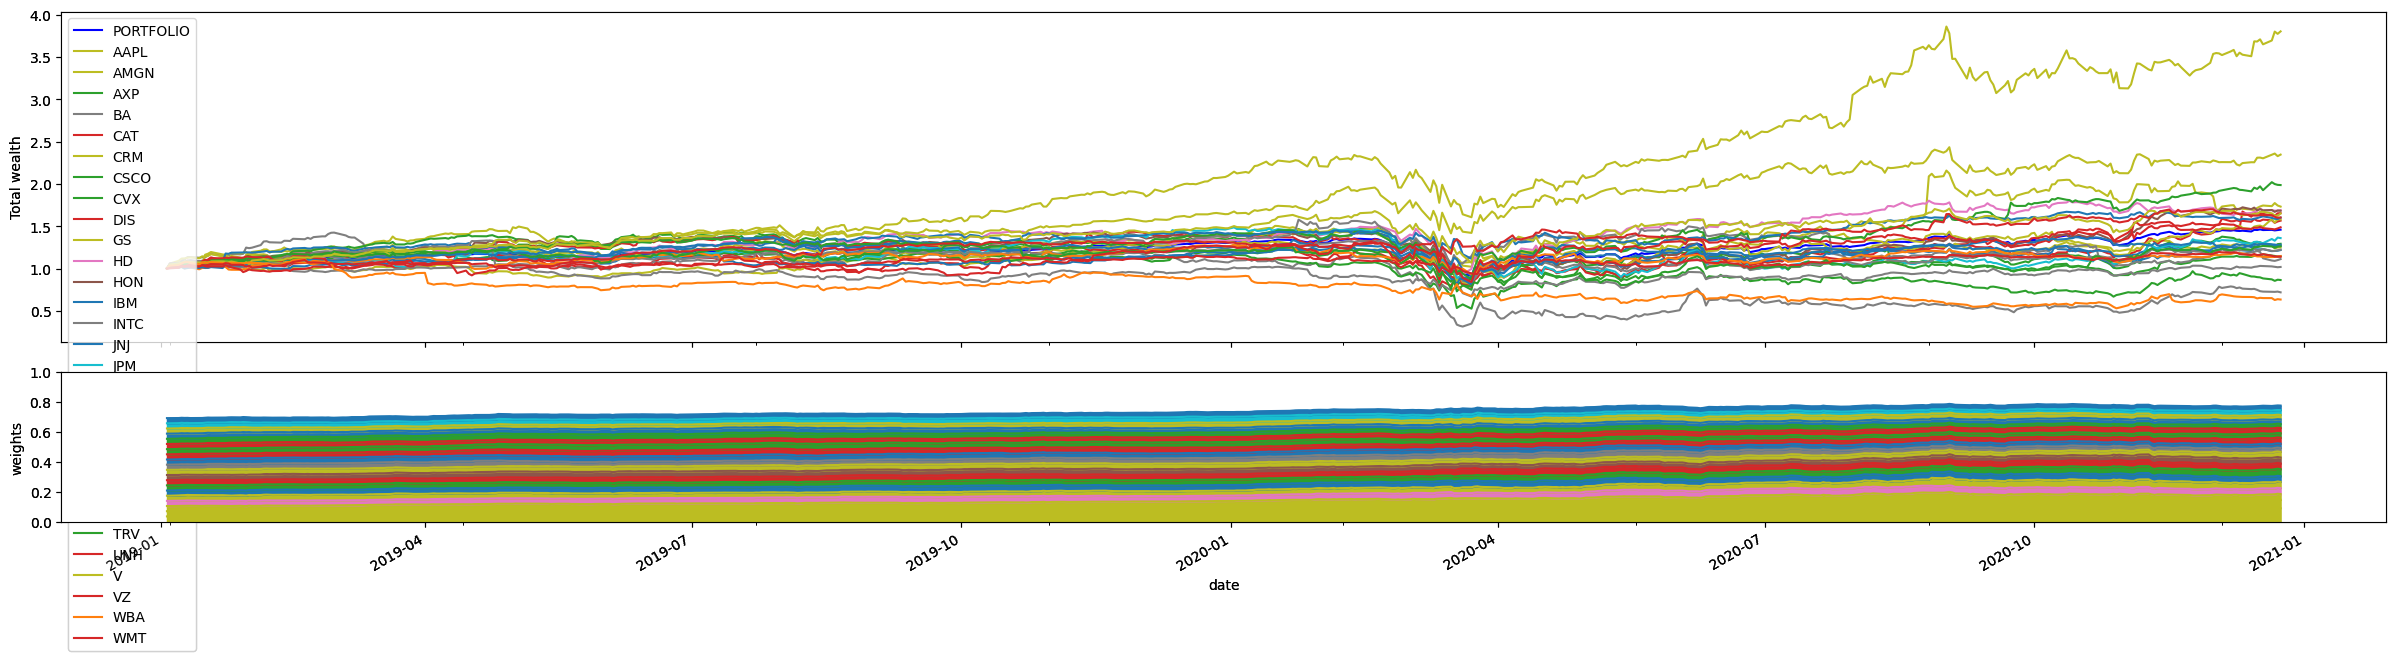

In [26]:
algo = BAH()
result = algo.run(pivot_df)

bah_B = result.B
bah_X = result.X
print(result.summary())
result.plot();

result_fee = result


# Here try setting a transaction fee
result_fee.fee = 0.001



bah_B_fee = result_fee.B
bah_X_fee = result_fee.X
print(result_fee.summary())
result_fee.plot();

Net Worth Over Time:
date
2019-01-03    1.000000e+06
2019-01-04    1.033162e+06
2019-01-07    1.038581e+06
2019-01-08    1.048707e+06
2019-01-09    1.051050e+06
                  ...     
2020-12-18    1.360691e+06
2020-12-21    1.362536e+06
2020-12-22    1.356325e+06
2020-12-23    1.359987e+06
2020-12-24    1.364179e+06
Length: 500, dtype: float64


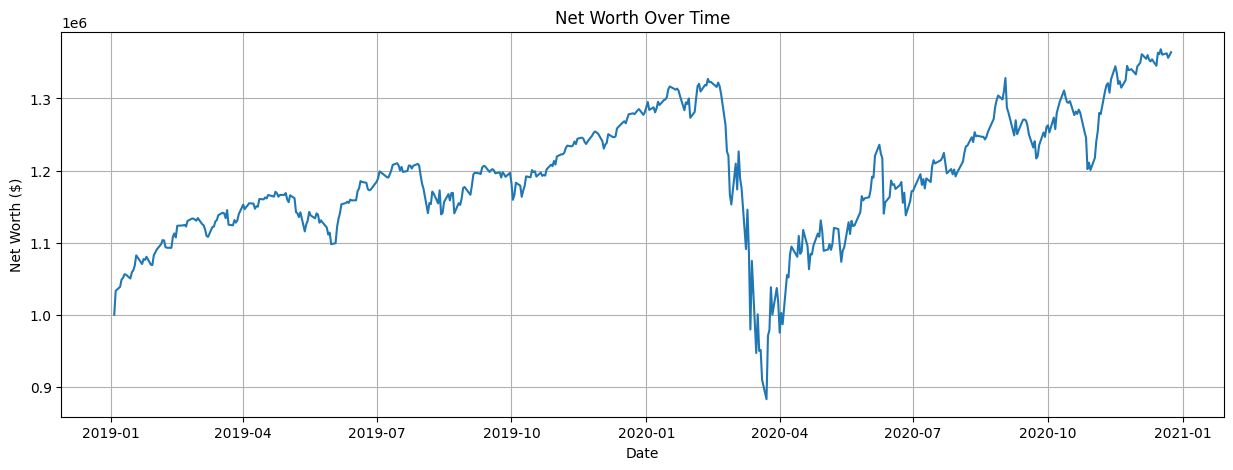

In [27]:
# Initial investment amount
initial_investment = 1000000

# Calculate final investment amount
# Calculate the net worth over time
net_worth_bah = calculate_final_investment(bah_X_fee, bah_B_fee, initial_investment, 0.001, 0.001)

print("Net Worth Over Time:")
print(net_worth_bah)

s = pd.Series(net_worth_bah, name='bah')

# Convert Series to DataFrame
bah_df_fee = s.to_frame()

# Plotting the net worth over time
plt.plot(net_worth_bah.index, net_worth_bah)
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.title('Net Worth Over Time')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (499, 8)
Annual return          0.154077
Cumulative returns     0.328111
Annual volatility      0.275422
Sharpe ratio           0.660169
Calmar ratio           0.415456
Stability              0.099859
Max drawdown          -0.370862
Omega ratio            1.156820
Sortino ratio          0.911544
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.863107
Daily value at risk   -0.033978
dtype: float64
df_dji:            date           dji
0   2019-01-03  1.000000e+06
1   2019-01-04  1.032925e+06
2   2019-01-07  1.037253e+06
3   2019-01-08  1.048542e+06
4   2019-01-09  1.052583e+06
..         ...           ...
495 2020-12-18  1.330281e+06
496 2020-12-21  1.331930e+06
497 2020-12-22  1.323072e+06
498 2020-12-23  1.328111e+06
499 2020-12-24           NaN

[500 rows x 2 columns]
df_dji:                       dji
date                    
2019-01-03  1.000000e+06
2019-01-04  1.032925e+06
2019-

<Figure size 1500x500 with 0 Axes>

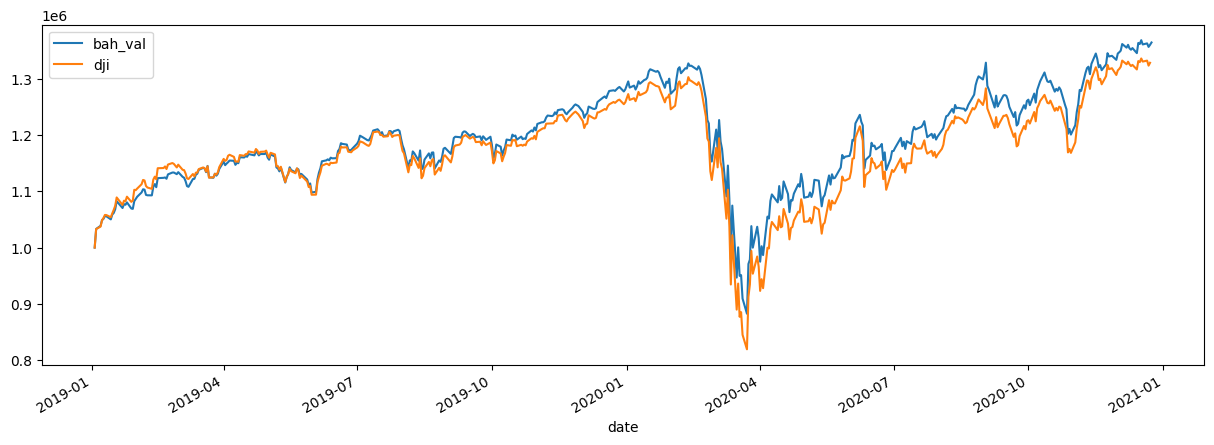

In [28]:
from finrl.plot import backtest_stats,  get_baseline

first_date = bah_df_fee.index.min()
last_date = bah_df_fee.index.max()

print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = first_date,
        end = last_date)

stats = backtest_stats(df_dji_, value_col_name = 'close')


df_dji = pd.DataFrame()
df_dji['date'] = bah_df_fee.index
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * initial_investment
print("df_dji: ", df_dji)
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


df_result_bah = pd.DataFrame({'date': bah_df_fee.index, 'bah_val': bah_df_fee['bah']})
df_result_bah = df_result_bah.set_index('date')

print("df_result_bah.columns: ", df_result_bah.columns)

print("df_result_bah: ", df_result_bah)
print("==============Compare to DJIA===========")
result = pd.DataFrame()

result = pd.merge(df_result_bah, df_dji, left_index=True, right_index=True)
print("result: ", result)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();